In [46]:
# ===========================
# MELANOMA CNN TRAINING PIPELINE
# ===========================
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

In [47]:
# ===========================
# 1️⃣ CONFIGURATION
# ===========================
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

BATCH_SIZE = 64
EPOCHS = 30
LR = 1e-4
IMG_SIZE = 224

print(f"Using device: {device}")

TRAIN_DIR = "/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/train"
TEST_DIR = "/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/data/test"

Using device: mps


In [48]:
import torch
print(torch.backends.mps.is_available())   # Should print True

True


In [49]:
print(f"Using device: {device}")
x = torch.rand(1, device=device)
print(x.device)

Using device: mps
mps:0


In [50]:
# ===========================
# 2️⃣ DATA TRANSFORMS
# ===========================
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.05),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Classes: ['Benign', 'Malignant']


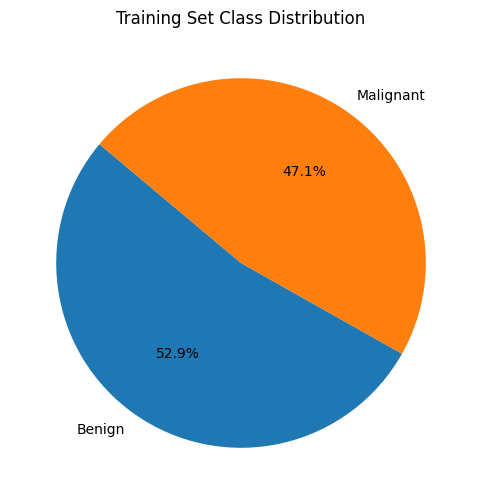

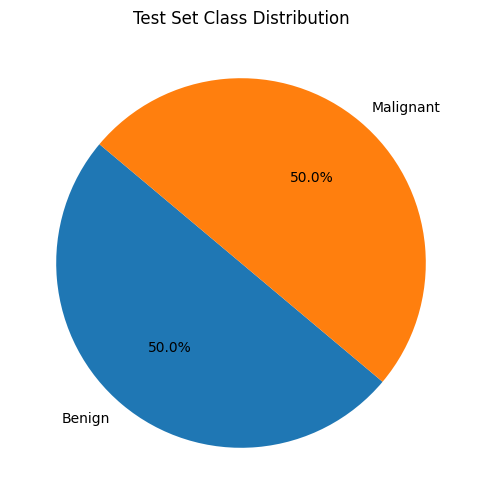

In [51]:
# ===========================
# 3️⃣ LOAD DATASETS
# ===========================
train_data = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_data = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_data.classes
print(f"Classes: {class_names}")

# visualize data, see how many benign or malignant samples we have in train and test using pie charts

def plot_class_distribution(data, title):
    labels, counts = np.unique(data.targets, return_counts=True)
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=[class_names[i] for i in labels], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()
plot_class_distribution(train_data, "Training Set Class Distribution")

plot_class_distribution(test_data, "Test Set Class Distribution")




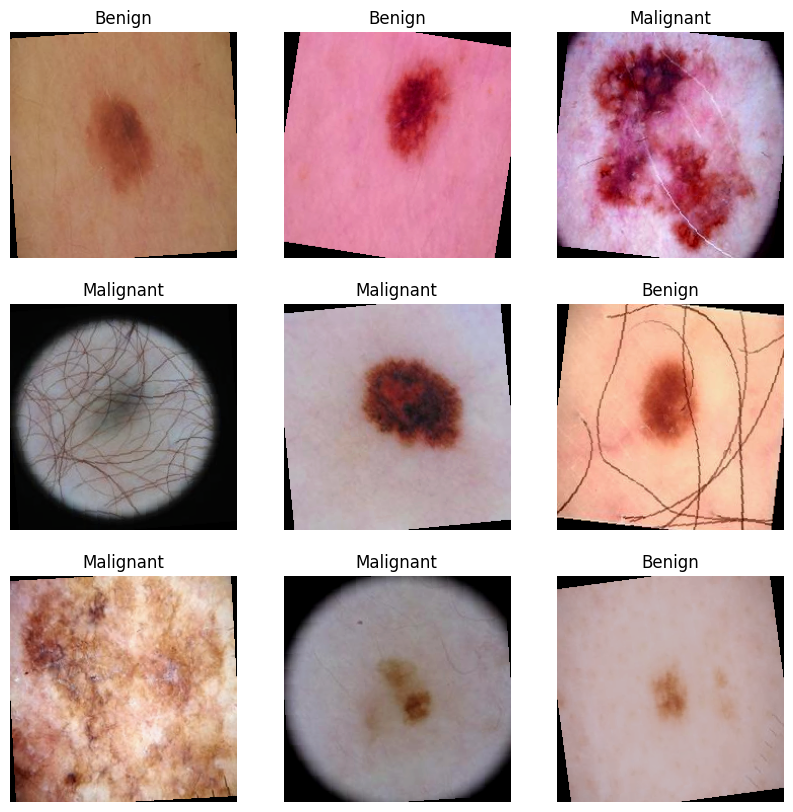

In [52]:
# ===========================
# 4️⃣ VISUALIZE TRANSFORMED IMAGES
# ===========================
def imshow_tensor(tensor, title=None):
    """Convert normalized tensor to displayable image."""
    img = tensor.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Preview a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow_tensor(images[i])
    plt.title(class_names[labels[i]])
plt.show()

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()

        # ---- Block 1 ----
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.2)

        # Projection for residual
        self.res1 = nn.Conv2d(3, 32, kernel_size=1)  # match channels

        # ---- Block 2 ----
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(0.3)

        self.res2 = nn.Conv2d(32, 64, kernel_size=1)

        # ---- Block 3 ----
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout(0.4)

        self.res3 = nn.Conv2d(64, 128, kernel_size=1)

        # ---- Fully connected ----
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.bn4 = nn.BatchNorm1d(256)
        self.drop4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # ---- Block 1 ----
        residual = self.res1(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = x + residual   # <-- out-of-place addition
        x = self.pool1(x)
        x = self.drop1(x)

        # ---- Block 2 ----
        residual = self.res2(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = x + residual
        x = self.pool2(x)
        x = self.drop2(x)

        # ---- Block 3 ----
        residual = self.res3(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        x = x + residual
        x = self.pool3(x)
        x = self.drop3(x)

        # ---- Fully connected ----
        x = torch.flatten(x, 1)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.drop4(x)
        logits = self.fc2(x)
        return logits

In [54]:
# ===========================
# 6️⃣ TRAINING SETUP
# ===========================
model = CustomCNN(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [55]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print(device)  # Should print mps if available, else cpu

mps


In [56]:
# ===========================
# 7️⃣ TRAINING LOOP WITH EARLY STOP & MIXED PRECISION
# ===========================

from torch.cuda.amp import autocast, GradScaler
import copy

# Parameters
patience = 5  # early stopping patience
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
epochs_no_improve = 0

scaler = GradScaler()  # for mixed precision

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Mixed precision context
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backprop with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)  # weighted by batch size

    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Training Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"⏹ Early stopping at epoch {epoch+1}")
            break

# Load best model weights
model.load_state_dict(best_model_wts)

/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_53503/821608219.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # for mixed precision
/var/folders/kg/jyh2bj6x1g9bg2wvqbvdtt100000gn/T/ipykernel_53503/821608219.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/30] - Training Loss: 0.4395
Epoch [2/30] - Training Loss: 0.3855
Epoch [3/30] - Training Loss: 0.3633
Epoch [4/30] - Training Loss: 0.3478
Epoch [5/30] - Training Loss: 0.3454
Epoch [6/30] - Training Loss: 0.3335
Epoch [7/30] - Training Loss: 0.3275
Epoch [8/30] - Training Loss: 0.3211
Epoch [9/30] - Training Loss: 0.3136
Epoch [10/30] - Training Loss: 0.3125
Epoch [11/30] - Training Loss: 0.3061
Epoch [12/30] - Training Loss: 0.2973
Epoch [13/30] - Training Loss: 0.2988
Epoch [14/30] - Training Loss: 0.2924
Epoch [15/30] - Training Loss: 0.2876
Epoch [16/30] - Training Loss: 0.2857
Epoch [17/30] - Training Loss: 0.2797
Epoch [18/30] - Training Loss: 0.2792
Epoch [19/30] - Training Loss: 0.2764
Epoch [20/30] - Training Loss: 0.2717
Epoch [21/30] - Training Loss: 0.2650
Epoch [22/30] - Training Loss: 0.2624
Epoch [23/30] - Training Loss: 0.2611
Epoch [24/30] - Training Loss: 0.2582
Epoch [25/30] - Training Loss: 0.2584
Epoch [26/30] - Training Loss: 0.2536
Epoch [27/30] - Train

<All keys matched successfully>

In [57]:
!say acabaste guapo

In [59]:
# ===========================
# 8️⃣ VALIDATION LOOP (MPS COMPATIBLE)
# ===========================

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []
all_probs = []
correct = 0
total = 0

threshold = 0.3  # Ajusta el umbral para "Malignant"

with torch.no_grad():  # No calcular gradientes
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass normal (sin autocast en MPS)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)  # ponderado por tamaño del batch

        # Probabilidades para "Malignant"
        probs = torch.softmax(outputs, dim=1)[:, 1]
        preds = (probs > threshold).long()  # Clasificación basada en umbral

        # Guardar resultados para métricas
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Exactitud estándar (argmax)
        _, argmax_preds = torch.max(outputs, 1)
        correct += (argmax_preds == labels).sum().item()
        total += labels.size(0)

# Calcular métricas
avg_loss = test_loss / len(test_loader.dataset)
accuracy = correct / total

print(f"✅ Validation Accuracy: {accuracy:.4f}")
print(f"Validation Loss: {avg_loss:.4f}")

# all_probs, all_preds, all_labels están listos para ROC, AUC, matriz de confusión, etc.

✅ Validation Accuracy: 0.8820
Validation Loss: 0.2842


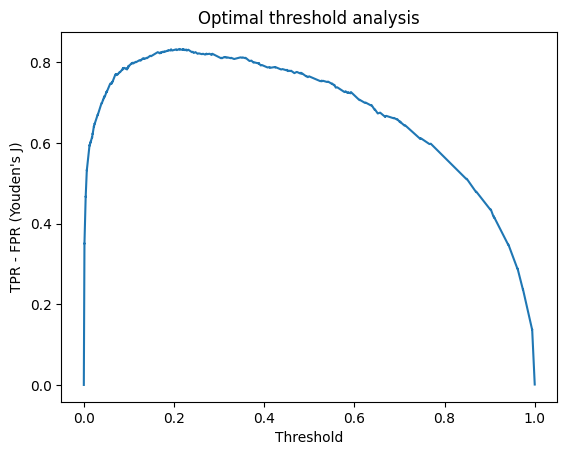

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)  # all_probs = list of model probs for class 1
plt.plot(thresholds, tpr - fpr)
plt.xlabel("Threshold")
plt.ylabel("TPR - FPR (Youden's J)")
plt.title("Optimal threshold analysis")
plt.show()

Confusion Matrix:
[[924  76]
 [112 888]]
AUC: 0.9689


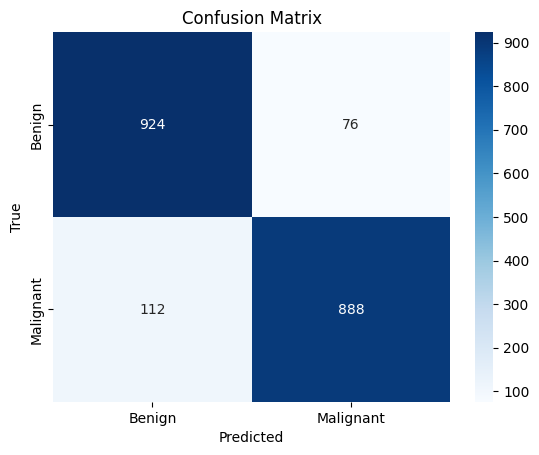

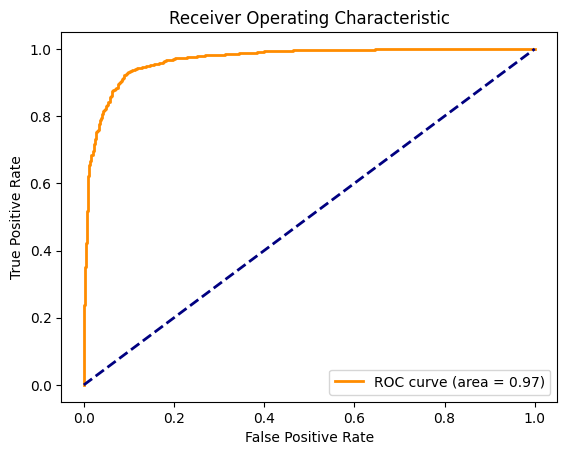

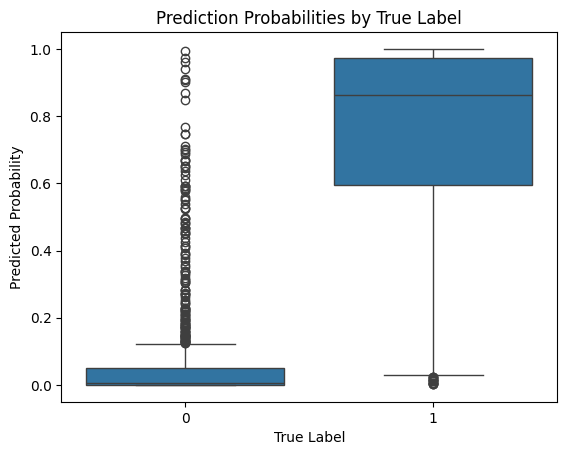

In [61]:
# 6. Metrics Calculation
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# 7. AUC ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# 8. Plotting
# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Boxplot of Predictions
sns.boxplot(x=all_labels, y=all_probs)
plt.xlabel('True Label')
plt.ylabel('Predicted Probability')
plt.title('Prediction Probabilities by True Label')
plt.show()

In [62]:
MODEL_PATH = '/Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/models/melanoma_model4.pth'
torch.save(model.state_dict(), MODEL_PATH)
print(f"✅ Model saved at {MODEL_PATH}")

✅ Model saved at /Users/frankllonch/Desktop/quattroporte/aprendizado de máquina/melanomator/models/melanoma_model4.pth
